In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
from ffmpeg_quality_metrics import FfmpegQualityMetrics as ffqm  # for VMAF calculation
from PIL import Image
import cv2
import os
import random

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


silent-house-2011.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/silent-house-2011.mp4
3666
printing frame number: 2961


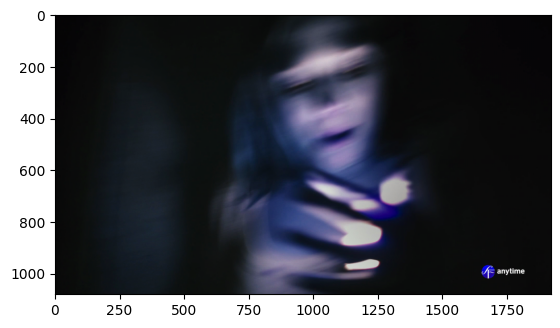

In [36]:
# läs in data och preprocessa

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

ret, frame = cap.read()

if ret:
    plt.imshow(frame)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


In [ ]:
"""
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
You need to turn them off during model evaluation, and .eval() will do it for you.
In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:
"""

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.eval()    # BUT, don't forget to turn back to training mode after eval step: model.train()